In [1]:
# modules importation
from trends_functions import *

Initating pyaerocom configuration
Checking database access...
Checking access to: /lustre/storeA
Access to lustre database: True
Init data paths for lustre
Expired time: 0.017 s


In [2]:
# computation parameters
params = {
    # minimum number of daily observations available in order to keep the station
    'min_dobs': 300,
    'min_nstat': 2,  # minimum number of stations required to compute median
    'sig': 0.95,  # significance
    'min_dim': 5,  # minimum number of days required to compute monthly mean
    'min_mis': 1,  # minimum number of months required to compute seasonal mean
    'min_siy': 4,  # minimum number of seasons required to compute annual mean
    'nseg': 2,  # number of segments if no significant linear trend on the time series is found
    # if use same segments for model and bias than the ones found in obs (to be run before)
    'use_obs_seg': True,
    'period': '1995-2018',
    'kind': None,  # 'obs' or 'mod'
    'var': None,
    'source': None,
    'ymin': None,
    'ymax': None,
    'ylabel': None
}

In [3]:
def to_date(dates):
    """Convert jsdate vector to datetime vector"""
    secs = [date/1000 for date in dates]
    dts = [datetime.datetime.fromtimestamp(sec) for sec in secs]
    return dts

In [4]:
def compute_trend(x, y, params, region):
    # function that provide a linear fit, if significant. If not, break out the function within nseg.

    # mann kendall test
    tau, pval = stats.kendalltau(x, y)

    # theil sen slope
    a, b, low_slope, up_slope = stats.mstats.theilslopes(
        y, x, alpha=params['sig'])
    # reproject on the whole period asked
    xb = np.arange(int(params['period'].split('-')[0]),
                   int(params['period'].split('-')[1]) + 1)
    reg = [a * i + b for i in xb]
    rel_slope = a * 100 / reg[0]

    slope_err = np.mean([abs(a - low_slope), abs(a - up_slope)])
    v0_err_data = np.mean(np.abs(y - [a * i + b for i in x]))
    trend_err = compute_trend_error(m=a, m_err=slope_err, v0=reg[0],
                                    v0_err=v0_err_data
                                    )

    trend = {
        str(xb[0]) + '-' + str(xb[-1]): {
            'x': xb,
            'xdate': [np.datetime64(str(y) + '-06-01') for y in xb],
            'y': reg,
            'a': a,
            'b': b,
            'rel_slp': rel_slope,
            'pval': pval,
            'err_rel_slp': trend_err
        }
    }

    trend1 = copy.copy(trend)
    pval1 = copy.copy(pval)
    short_period = False

    # if (kind=='obs' and pval>(1-sig)) or ((kind!='obs' and use_obs_seg)):
    if (params['kind'] == 'obs') or ((params['kind'] != 'obs' and params['use_obs_seg'])):

        # first, find break points
        #print('needs to break the series')
        # initialize piecewise linear fit with your x and y data
        my_pwlf = pwlf.PiecewiseLinFit(x, y)
        if params['kind'] != 'obs' and params['use_obs_seg']:
            #print('use obs segments')
            # fit the data for nseg line segments
            segs = list(OBS_MAP[region]['trends']['trends'].keys())
            if len(segs) <= 1:
                #print('obs do not have segments')
                # print(trend)
                return trend
            else:
                trend = {}
                breaks = [int(segs[0].split('-')[0]),
                          int(segs[0].split('-')[1]), int(segs[1].split('-')[1])]
                #print('obs breaks: ',breaks)
        else:
            trend = {}
            # fit the data for nseg line segments
            breaks = [int(round(x)) for x in my_pwlf.fit(params['nseg'])]

        # loop over segments
        for i in np.arange(params['nseg']):
            mask = [(x >= breaks[i]) & (x <= breaks[i + 1])]
            x2 = x[mask]
            y2 = y[mask]

            if (len(x2) > 3):
                # mann kendall test
                tau, pval = stats.kendalltau(x2, y2)
                # theil sen slope
                a, b, low_slope, up_slope = stats.mstats.theilslopes(
                    y2, x2, alpha=params['sig'])
                # reproject on the whole period asked for first and last segment
                xb = x2
                if i == 0:
                    xb = np.arange(
                        int(params['period'].split('-')[0]), x2[-1] + 1)
                if i == params['nseg']:
                    xb = np.arange(x2[0], int(
                        params['period'].split('-')[1]) + 1)

                reg = [a * i + b for i in xb]
                rel_slope = a * 100 / reg[0]

                slope_err = np.mean([abs(a - low_slope), abs(a - up_slope)])
                v0_err_data = np.mean(np.abs(y2 - [a * i + b for i in x2]))
                trend_err = compute_trend_error(
                    m=a, m_err=slope_err, v0=reg[0], v0_err=v0_err_data)

                trend[str(xb[0]) + '-' + str(xb[-1])] = {
                    'x': xb,
                    'xdate': [np.datetime64(str(y) + '-06-01') for y in xb],
                    'y': reg,
                    'a': a,
                    'b': b,
                    'rel_slp': rel_slope,
                    'pval': pval,
                    'err_rel_slp': trend_err
                }
            else:
                xb = x2
                if len(xb)==0:
                    xb = [breaks[i], breaks[i+1]]
                trend[str(xb[0]) + '-' + str(xb[-1])] = {
                    'x': [],
                    'xdate': [],
                    'y': [],
                    'a': None,
                    'b': None,
                    'rel_slp': None,
                    'pval': None,
                    'err_rel_slp': None
                }
                short_period = True

    # compare p-values
    if params['kind'] == 'obs':
        seg_pval = []
        for seg in trend.keys():
            if (trend[seg]['pval'] != None):
                seg_pval.append(trend[seg]['pval'])
        if min(seg_pval) >= pval1 or short_period == True:
            trend = trend1

    # compute trend along time series
    return trend

In [5]:
def process_trend(data, params, obs=None, colocate_time=True,
                  colocate_space=True, plot=True, write_json=False,
                  show_plot=False, save_plot=False):
    # by default, colocate model in space and time
    MAP, DF,  ALL_TS = {}, {}, {}
    regions = pya.region.all()
    regions = ['EUROPE', 'ASIA', 'AUSTRALIA',
               'NAFRICA', 'SAFRICA', 'NAMERICA', 'SAMERICA']

    # computation region by region
    for region in regions:
        f = pya.Filter(region)
        if params['kind'] == 'obs':
            try:
                sub = f(data)
                var = data.vars_to_retrieve[0]
                obs_var = var
            except:
                print('No station found in the area')
                MAP[region] = {
                    'name': region,
                    'min_lon': pya.Region(region).lon_range[0],
                    'max_lon': pya.Region(region).lon_range[1],
                    'min_lat': pya.Region(region).lat_range[0],
                    'max_lat': pya.Region(region).lat_range[1],
                    'trends': {},
                    'nmax': 0,
                    'stations': [],
                }
                continue
        elif params['kind'] == 'mod':
            if obs == None:
                print('kind is model. Needs to pass an obs dataset')
            else:
                try:
                    sub = f(obs)
                    var = data.var_name
                except:
                    print('No station found in the area')
                    MAP[region] = {
                        'name': region,
                        'min_lon': pya.Region(region).lon_range[0],
                        'max_lon': pya.Region(region).lon_range[1],
                        'min_lat': pya.Region(region).lat_range[0],
                        'max_lat': pya.Region(region).lat_range[1],
                        'trends': {},
                        'nmax': 0,
                        'stations': [],
                    }
                    continue

        # for each subset, creates a dataframe containing all stations timeseries
        # first, get station data
        data_all = sub.to_station_data_all()['stats']
        obs_all = copy.copy(data_all)

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        # if model
        if params['kind'] == 'mod':
            obs_var = obs.vars_to_retrieve[0]
            if colocate_space:
                # first, get list of stations name, lat and lon
                stations = {'name': [], 'lat': [], 'lon': []}

                for stat in data_all:
                    stations['name'].append(stat['station_name'])
                    stations['lat'].append(stat['station_coords']['latitude'])
                    stations['lon'].append(stat['station_coords']['longitude'])

                data_all = data.to_time_series(
                    longitude=stations['lon'], latitude=stations['lat'],
                    add_meta=dict(station_name=stations['name'])
                )
            else:
                data_all = f(data)
                med_area = data_all.get_area_weighted_timeseries()
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

        # initialize pandas DataFrame
        df = pd.DataFrame()

        stations = []
        if params['kind'] == 'mod' and colocate_space == False:
            med = med_area[var]
            top = med
            bottom = med
            ts = med.to_frame()
            ts.set_axis([obs_var + '_' + region], axis=1, inplace=True)
            df = pd.concat([df, ts], axis=1)
        else:
            for i, station in enumerate(data_all):
                stat_name = station.station_name
                print('region: ', region, 'station: ', stat_name, end="\r")
                ts_type = station.ts_type
                # set individual time series as dataframe

                # extract pandas series and convert it to datframe
                ts = data_all[i][var].to_frame()
                # remove duplicated index keeping the first occuence
                ts = ts.groupby(ts.index).first()
                #name the columns
                ts.set_axis([obs_var + '_' + stat_name], axis=1, inplace=True)

                if ts_type == 'daily':
                    if ts.count()[0] >= params['min_dobs']:
                        # concatenates to main dataframe
                        df = pd.concat([df, ts], axis=1)
                else:
                    # concatenates to main dataframe
                    df = pd.concat([df, ts], axis=1)

                stations.append({
                    'name': stat_name,
                    'lat': station.latitude,
                    'lon': station.longitude
                })
            # clear_output(wait=False)

            # caluclates median and envelope with quartiles
            med = df.median(axis=1)
            top = df.quantile(q=0.75, axis=1)
            bottom = df.quantile(q=0.25, axis=1)
            # requires at least n measurements to provide a valid median
            n = df.count(axis=1, numeric_only=False)
            med = med[n > params['min_nstat']]
            top = top[n > params['min_nstat']]
            bottom = bottom[n > params['min_nstat']]
        
        if params['kind'] == 'obs':
            #drop the time from datetime index by computing daily average
            df = df.resample('D', how='mean')

        # if model, colocates in time with obs
        if params['kind'] == 'mod' and colocate_time:
            if region in OBS_DF.keys():
                #if monthly values: set day to 1
                if params['min_dim'] == 0:
                    #print('min_dim==0')
                    print()
                    print('monthly data. set day to 1')
                    idx = df.index.values.astype('datetime64[M]')
                    df = df.set_index(idx)
                    df = df[OBS_DF[region].resample('D', how='mean') >= 0]
                    #df = df[OBS_DF[region]>= 0]
                else:
                    #if hourly or daily
                    df = df[OBS_DF[region].resample('D', how='mean') >= 0]
                #df = df[OBS_DF[region] >= 0]
                # caluclates median and envelope with quartiles
                med = df.median(axis=1)
                top = df.quantile(q=0.75, axis=1)
                bottom = df.quantile(q=0.25, axis=1)
                # requires at least n measurements to provide a valid median
                n = df.count(axis=1, numeric_only=False)
                med = med[n > params['min_nstat']]
                top = top[n > params['min_nstat']]
                bottom = bottom[n > params['min_nstat']]
            else:
                continue

        # calculates monthly averages for the plots
        dcount = med.groupby(pd.Grouper(freq='M')).count()
        mmed = med.groupby(pd.Grouper(freq='M')).mean().where(
            dcount >= params['min_dim'])
        mtop = top.groupby(pd.Grouper(freq='M')).mean().where(
            dcount >= params['min_dim'])
        mbottom = bottom.groupby(pd.Grouper(
            freq='M')).mean().where(dcount >= params['min_dim'])

        # seasonal averages
        mcount = mmed.groupby(pd.Grouper(freq='Q')).count()
        smed = mmed.groupby(pd.Grouper(freq='Q')
                            ).mean().where(mcount >= params['min_mis'])

        # yearly averages from seasonal averages
        scount = smed.groupby(pd.Grouper(freq='A')).count()
        ymed = smed.groupby(pd.Grouper(freq='A')
                            ).mean().where(scount >= params['min_siy'])
        ymed = ymed.shift(-6, freq='MS')

        y_min = int(params['period'].split('-')[0])
        y_max = int(params['period'].split('-')[1])

        # prepare arrays for trends computation
        x = ymed.index.year.values
        xplot = ymed.index
        y = ymed.values
        # get only valid values
        x = x[~np.isnan(y)]
        xplot = xplot[~np.isnan(y)]
        y = y[~np.isnan(y)]

        # restrict to years within period
        xok, yok = [], []
        for i, _ in enumerate(x):
            if x[i] >= y_min and x[i] <= y_max:
                xok.append(x[i])
                yok.append(y[i])
        xok = np.array(xok)
        yok = np.array(yok)

        # write ts json file
        TS = {
            "daily": {
                "jsdate": to_jsdate(med.index).tolist(),
                "data": med.values.tolist(),
                "top": top.values.tolist(),
                "bottom": bottom.values.tolist()
            },
            "monthly": {
                "jsdate": to_jsdate(mmed.index).tolist(),
                "data": mmed.values.tolist(),
                "top": mtop.values.tolist(),
                "bottom": mbottom.values.tolist()
            },
            "yearly": {
                "jsdate": to_jsdate(ymed.index).tolist(),
                "data": ymed.values.tolist(),
            },
            "trends": {}
        }

        # trends computation
        if len(xok) < 4:
            print()
            print('Less than 4 points in selected period')
            MAP[region] = {
                'name': region,
                'min_lon': pya.Region(region).lon_range[0],
                'max_lon': pya.Region(region).lon_range[1],
                'min_lat': pya.Region(region).lat_range[0],
                'max_lat': pya.Region(region).lat_range[1],
                'trends': TS,
                'nmax': len(df.columns),
                'stations': stations
            }
            continue
        
        trend = compute_trend(xok, yok, params, region)

        if plot:
            plotTS(mmed, mbottom, mtop, ymed, trend,
                   region, params, show_plot, save_plot)

        # store every portions of the trend
        for seg in trend.keys():
            if trend[seg]['rel_slp'] != None:
                jsdate = to_jsdate(trend[seg]['xdate']).tolist()
            else:
                jsdate = []
            TS["trends"][seg] = {
                'pval': trend[seg]['pval'],
                'rel_slp': trend[seg]['rel_slp'],
                'abs_slp': trend[seg]['a'],
                'reg0': trend[seg]['b'],
                'n': len(trend[seg]['x']),
                'data': trend[seg]['y'],
                'jsdate': jsdate,
                'err_rel_slp': trend[seg]['err_rel_slp']
            }

        # export TS as json file
        if write_json:
            write_ts(TS, region, params)

        # append to map dict
        MAP[region] = {
            'name': region,
            'min_lon': pya.Region(region).lon_range[0],
            'max_lon': pya.Region(region).lon_range[1],
            'min_lat': pya.Region(region).lat_range[0],
            'max_lat': pya.Region(region).lat_range[1],
            'trends': TS,
            'nmax': len(df.columns),
            'stations': stations,
        }

        ALL_TS[region] = TS
        DF[region] = df

    # export MAP as json file
    if write_json:
        write_map(MAP, params)
        write_all_ts(ALL_TS, params)

    return TS, MAP, DF

In [6]:
# run observations
# 'ang4487aer' 'od550aer' 'od550gt1aer' 'od550lt1aer' 'sconcpm10' 'sconcpm25' 'sconcso4'
var = 'od550aer'
params['kind'] = 'obs'
if var == 'od550aer':
    params['source'] = 'AeronetSunV3Lev2.daily'
    params['ymin'] = 0
    params['ymax'] = 0.8
    params['ylabel'] = 'AOD'
    params['min_dim'] = 5
if var == 'ang4487aer':
    params['source'] = 'AeronetSunV3Lev2.daily'
    params['ymin'] = 0
    params['ymax'] = 2.5
    params['ylabel'] = 'AE'
    params['min_dim'] = 5
if var == 'od550gt1aer':
    params['source'] = 'AeronetSDAV3Lev2.daily'
    params['ymin'] = 0
    params['ymax'] = 0.8
    params['ylabel'] = 'AOD>1µm'
    params['min_dim'] = 5
if var == 'od550lt1aer':
    params['source'] = 'AeronetSDAV3Lev2.daily'
    params['ymin'] = 0
    params['ymax'] = 0.8
    params['ylabel'] = 'AOD<1µm'
    params['min_dim'] = 5
if var == 'concpm10':
    params['source'] = 'EBASMC'
    params['ymin'] = 0
    params['ymax'] = 60
    params['ylabel'] = 'PM10'
    params['min_dim'] = 4  # weekly measurements
if var == 'concpm25':
    params['source'] = 'EBASMC'
    params['ymin'] = 0
    params['ymax'] = 30
    params['ylabel'] = 'PM2.5'
    params['min_dim'] = 4  # weekly measurements
if var == 'sconcso4':
    params['source'] = 'GAWTADsubsetAasEtAl'
    params['ymin'] = 0
    params['ymax'] = 6
    params['ylabel'] = 'SO4'
    params['min_dim'] = 0  # monthly measurements

params['var'] = var
obs_source = params['source']
reader = pya.io.ReadUngridded(obs_source)
obs_data = reader.read(vars_to_retrieve=var)

In [7]:
_, OBS_MAP, OBS_DF = process_trend(
    obs_data, params,
    plot=False, show_plot=False, save_plot=False, write_json=False
)

Input time frequency equals current frequency of data, ignoring any resampling constraints
Input time frequency equals current frequency of data, ignoring any resampling constraints


/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`

Input time frequency equals current frequency of data, ignoring any resampling constraints
Input time frequency equals current frequency of data, ignoring any resampling constraints


In [8]:
MOD_MAP, MOD_DF = {}, {}

# run models
#'GFDL-AM4-amip_HIST' if var == 'od550lt1aer' || var == 'od550gt1aer' || 
mod_var = var
params['kind'] = 'mod'
#params['min_nstat'] = 2 #if colocate already in time and space

all_mods = ['ECMWF_CAMS_REAN', 'OsloCTM3v1.01-met2010_AP3-HIST', 
            'NorESM2-LM_historical', 'BCC-CUACE_HIST', 'CAM5-ATRAS_AP3-HIST', 
            'GFDL-AM4-amip_HIST', 'CanESM5_historical', 'CESM2_historical',
            'E3SM-1-0_historical', 'IPSL-CM6A-LR_historical']

#prepare colors
current_palette = sns.color_palette("deep", 12)
all_colors = {}
for i, mod in enumerate(all_mods):
    all_colors[mod] = current_palette[i]

sources = {
    'all': all_mods,
    'colors': all_colors,
    'od550aer': ['IPSL-CM6A-LR_historical']
}


if var == 'od550aer':
    params['ymin'] = 0
    params['ymax'] = 0.8
    params['ylabel'] = 'AOD'
    params['min_dim'] = 0
if var == 'ang4487aer':
    params['ymin'] = 0
    params['ymax'] = 2.5
    params['ylabel'] = 'AE'
    params['min_dim'] = 0
if var == 'od550gt1aer':
    params['ymin'] = 0
    params['ymax'] = 0.8
    params['ylabel'] = 'AOD>1µm'
    params['min_dim'] = 0
if var == 'od550lt1aer':
    params['ymin'] = 0
    params['ymax'] = 0.8
    params['ylabel'] = 'AOD<1µm'
    params['min_dim'] = 0
if var == 'concpm10':
    params['ymin'] = 0
    params['ymax'] = 60
    params['ylabel'] = 'PM10'
    params['min_dim'] = 0
if var == 'concpm25':
    params['ymin'] = 0
    params['ymax'] = 30
    params['ylabel'] = 'PM2.5'
    params['min_dim'] = 0
if var == 'sconcso4':
    params['ymin'] = 0
    params['ymax'] = 6
    params['ylabel'] = 'SO4'
    params['min_dim'] = 0

import pickle
import os
mod_sources = sources[var]
for mod_source in mod_sources:
    print(mod_source)
    print()
    params['source'] = mod_source
    
    #check if model in cache
    fn = 'cache/'+mod_source+'_'+var+'.pkl'
    if os.path.isfile(fn):
        print('use pickle')
        # for reading also binary mode is important 
        pklfile = open(fn, 'rb')      
        mod_data = pickle.load(pklfile) 
        pklfile.close()
    else:
        reader = pya.io.ReadGridded(mod_source)
        mod_data = reader.read_var(mod_var, ts_type='daily')
        mod_data = mod_data.resample_time(to_ts_type='monthly')

        #write picke file in cache directory
        pklfile = open(fn, 'ab') 

        # source, destination 
        pickle.dump(mod_data, pklfile)                      
        pklfile.close()

    #full colocation
    _, MOD_MAP[mod_source], MOD_DF[mod_source], = process_trend(
        mod_data, params, obs=obs_data,
        colocate_time=True, colocate_space=True,
        plot=False, show_plot=False, save_plot=False, write_json=False
    )

IPSL-CM6A-LR_historical

use pickle


Input time frequency equals current frequency of data, ignoring any resampling constraints
Input time frequency equals current frequency of data, ignoring any resampling constraints
Interpolating data of shape (1980, 143, 144). This may take a while.
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/iris/analysis/_scipy_interpolate.py:290: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differen

region:  EUROPE station:  Zvenigorodurgitutea
monthly data. set day to 1


/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:143: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
Interpolating data of shape (1980, 143, 144). This may take a while.
Successfully interpolated cube


region:  ASIA station:  Zhongshan_UnivityDh
monthly data. set day to 1


/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Interpolating data of shape (1980, 143, 144). This may take a while.
Successfully interpolated cube


region:  AUSTRALIA station:  Tinga_Tingana
monthly data. set day to 1


Interpolating data of shape (1980, 143, 144). This may take a while.
Successfully interpolated cube


region:  NAFRICA station:  Zinder_DMNporttutea
monthly data. set day to 1


Interpolating data of shape (1980, 143, 144). This may take a while.
Successfully interpolated cube


region:  SAFRICA station:  Zambeziiversityort
monthly data. set day to 1


Input time frequency equals current frequency of data, ignoring any resampling constraints
Input time frequency equals current frequency of data, ignoring any resampling constraints



Less than 4 points in selected period


Interpolating data of shape (1980, 143, 144). This may take a while.
Successfully interpolated cube


region:  NAMERICA station:  Yumaowknife_Aurorao
monthly data. set day to 1


Interpolating data of shape (1980, 143, 144). This may take a while.
Successfully interpolated cube


region:  SAMERICA station:  Veracruz_MAX_MEXFOP
monthly data. set day to 1


In [10]:
MOD_MAP, MOD_DF = {}, {}

# run models
#'GFDL-AM4-amip_HIST' if var == 'od550lt1aer' || var == 'od550gt1aer' || 
mod_var = var
params['kind'] = 'mod'
#params['min_nstat'] = 2 #if colocate already in time and space

#full colocation
data = mod_data
obs = obs_data
colocate_time = True
colocate_space = True

In [11]:
# by default, colocate model in space and time
MAP, DF,  ALL_TS = {}, {}, {}
region = 'SAFRICA'

# computation region by region
f = pya.Filter(region)
if params['kind'] == 'obs':
    try:
        sub = f(data)
        var = data.vars_to_retrieve[0]
        obs_var = var
    except:
        print('No station found in the area')
        MAP[region] = {
            'name': region,
            'min_lon': pya.Region(region).lon_range[0],
            'max_lon': pya.Region(region).lon_range[1],
            'min_lat': pya.Region(region).lat_range[0],
            'max_lat': pya.Region(region).lat_range[1],
            'trends': {},
            'nmax': 0,
            'stations': [],
        }
elif params['kind'] == 'mod':
    if obs == None:
        print('kind is model. Needs to pass an obs dataset')
    else:
        try:
            sub = f(obs)
            var = data.var_name
        except:
            print('No station found in the area')
            MAP[region] = {
                'name': region,
                'min_lon': pya.Region(region).lon_range[0],
                'max_lon': pya.Region(region).lon_range[1],
                'min_lat': pya.Region(region).lat_range[0],
                'max_lat': pya.Region(region).lat_range[1],
                'trends': {},
                'nmax': 0,
                'stations': [],
            }

/home/augustinm/Dev/pyaerocom/pyaerocom/pyaerocom/ungriddeddata.py:123: RuntimeWarning: invalid value encountered in multiply
  self._data = np.empty([num_points, self._COLNO]) * np.nan


In [12]:
# for each subset, creates a dataframe containing all stations timeseries
# first, get station data
data_all = sub.to_station_data_all()['stats']
obs_all = copy.copy(data_all)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# if model
if params['kind'] == 'mod':
    obs_var = obs.vars_to_retrieve[0]
    if colocate_space:
        # first, get list of stations name, lat and lon
        stations = {'name': [], 'lat': [], 'lon': []}

        for stat in data_all:
            stations['name'].append(stat['station_name'])
            stations['lat'].append(stat['station_coords']['latitude'])
            stations['lon'].append(stat['station_coords']['longitude'])

        data_all = data.to_time_series(
            longitude=stations['lon'], latitude=stations['lat'],
            add_meta=dict(station_name=stations['name'])
        )
    else:
        data_all = f(data)
        med_area = data_all.get_area_weighted_timeseries()
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Interpolating data of shape (1980, 143, 144). This may take a while.
Successfully interpolated cube


In [82]:
# initialize pandas DataFrame
df = pd.DataFrame()

stations = []
if params['kind'] == 'mod' and colocate_space == False:
    med = med_area[var]
    top = med
    bottom = med
    ts = med.to_frame()
    ts.set_axis([obs_var + '_' + region], axis=1, inplace=True)
    df = pd.concat([df, ts], axis=1)
else:
    for i, station in enumerate(data_all):
        stat_name = station.station_name
        print('region: ', region, 'station: ', stat_name, end="\r")
        ts_type = station.ts_type
        # set individual time series as dataframe

        # extract pandas series and convert it to datframe
        ts = data_all[i][var].to_frame()
        # remove duplicated index keeping the first occuence
        ts = ts.groupby(ts.index).first()
        #name the columns
        ts.set_axis([obs_var + '_' + stat_name], axis=1, inplace=True)

        if ts_type == 'daily':
            if ts.count()[0] >= params['min_dobs']:
                # concatenates to main dataframe
                df = pd.concat([df, ts], axis=1)
        else:
            # concatenates to main dataframe
            df = pd.concat([df, ts], axis=1)

        stations.append({
            'name': stat_name,
            'lat': station.latitude,
            'lon': station.longitude
        })
    # clear_output(wait=False)

    # caluclates median and envelope with quartiles
    med = df.median(axis=1)
    top = df.quantile(q=0.75, axis=1)
    bottom = df.quantile(q=0.25, axis=1)
    # requires at least n measurements to provide a valid median
    n = df.count(axis=1, numeric_only=False)
    med = med[n > params['min_nstat']]
    top = top[n > params['min_nstat']]
    bottom = bottom[n > params['min_nstat']]

if params['kind'] == 'obs':
    #drop the time from datetime index by computing daily average
    df = df.resample('D', how='mean')

In [83]:
print(df.columns)

Index(['od550aer_Ben_McDhui', 'od550aer_Bethlehem', 'od550aer_Bonanza',
       'od550aer_Bujumbura', 'od550aer_CRPSM_Malindi',
       'od550aer_DRAGON_Henties_1', 'od550aer_DRAGON_Henties_2',
       'od550aer_DRAGON_Henties_3', 'od550aer_DRAGON_Henties_4',
       'od550aer_DRAGON_Henties_5', 'od550aer_DRAGON_Henties_6',
       'od550aer_Durban_UKZN', 'od550aer_Elandsfontein', 'od550aer_Etosha_Pan',
       'od550aer_Gobabeb', 'od550aer_Gorongosa', 'od550aer_HESS',
       'od550aer_Henties_Bay', 'od550aer_Huambo', 'od550aer_ICIPE-Mbita',
       'od550aer_Inhaca', 'od550aer_Joberg', 'od550aer_Kaoma',
       'od550aer_Loskop_Dam', 'od550aer_Lubango', 'od550aer_Maun_Tower',
       'od550aer_Misamfu', 'od550aer_Mongu', 'od550aer_Mongu_Inn',
       'od550aer_Mwinilunga', 'od550aer_Nairobi', 'od550aer_Namibe',
       'od550aer_Ndola', 'od550aer_Paardefontein', 'od550aer_Pietersburg',
       'od550aer_Possession_Island', 'od550aer_Potchefstroom',
       'od550aer_Pretoria_CSIR-DPSS', 'od550aer_

In [85]:
# if model, colocates in time with obs
if params['kind'] == 'mod' and colocate_time:
    if region in OBS_DF.keys():
        #if monthly values: set day to 1
        if params['min_dim'] == 0:
            #print('min_dim==0')
            print()
            print('colocate monthly dataframes')
            df = df.resample('M', how='mean')
            df_obs =  OBS_DF[region].resample('M', how='mean')
            
            df = df[df_obs >= 0]
            #df = df[OBS_DF[region]>= 0]
        else:
            #if hourly or daily
            df = df[OBS_DF[region].resample('D', how='mean') >= 0]
        #df = df[OBS_DF[region] >= 0]
        # caluclates median and envelope with quartiles
        med = df.median(axis=1)
        top = df.quantile(q=0.75, axis=1)
        bottom = df.quantile(q=0.25, axis=1)
        # requires at least n measurements to provide a valid median
        n = df.count(axis=1, numeric_only=False)
        med = med[n > params['min_nstat']]
        top = top[n > params['min_nstat']]
        bottom = bottom[n > params['min_nstat']]
    else:
        print('continue')


colocate monthly dataframes


/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  # Remove the CWD from sys.path while we load stuff.
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


Text(0.5, 1.0, 'df full colocate')

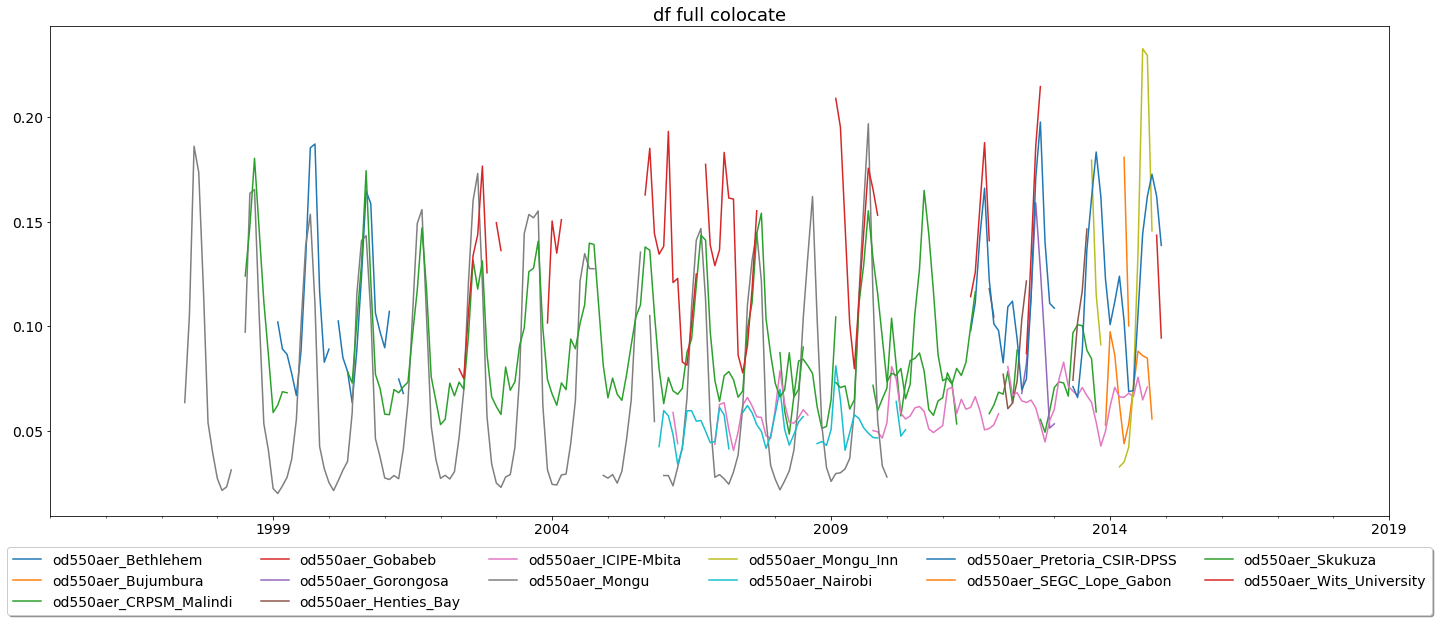

In [87]:
#drop empty columns
df2 = df.dropna(axis='columns', how='all')

df2.plot()
plt.xlim('1995-01-01','2019-01-01')

fig = plt.gcf()
fig.set_size_inches(12, 10)
ax = plt.subplot(111)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width*2, box.height * 0.9])

ax.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)
plt.title('df full colocate')

/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 1.0, 'obs')

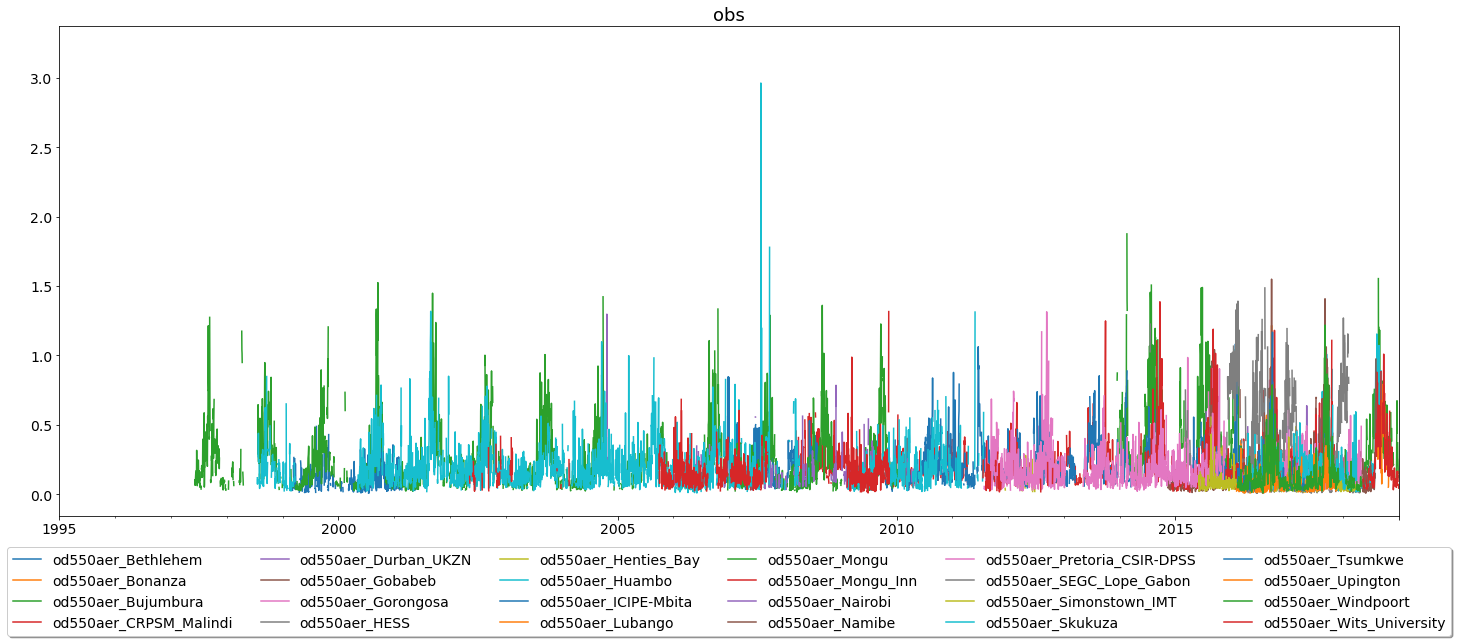

In [88]:
df_obs = OBS_DF['SAFRICA']
#monthly 
df_obs.plot()
plt.xlim('1995-01-01','2019-01-01')

fig = plt.gcf()
fig.set_size_inches(12, 10)
ax = plt.subplot(111)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width*2, box.height * 0.9])

ax.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)
plt.title('obs')

In [89]:
df_obs

,od550aer_Bethlehem,od550aer_Bonanza,od550aer_Bujumbura,od550aer_CRPSM_Malindi,od550aer_Durban_UKZN,od550aer_Gobabeb,od550aer_Gorongosa,od550aer_HESS,od550aer_Henties_Bay,od550aer_Huambo,...,od550aer_Nairobi,od550aer_Namibe,od550aer_Pretoria_CSIR-DPSS,od550aer_SEGC_Lope_Gabon,od550aer_Simonstown_IMT,od550aer_Skukuza,od550aer_Tsumkwe,od550aer_Upington,od550aer_Windpoort,od550aer_Wits_University
1997-05-12,0.086442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# calculates monthly averages for the plots
dcount = med.groupby(pd.Grouper(freq='M')).count()
mmed = med.groupby(pd.Grouper(freq='M')).mean().where(
    dcount >= params['min_dim'])
mtop = top.groupby(pd.Grouper(freq='M')).mean().where(
    dcount >= params['min_dim'])
mbottom = bottom.groupby(pd.Grouper(
    freq='M')).mean().where(dcount >= params['min_dim'])

# seasonal averages
mcount = mmed.groupby(pd.Grouper(freq='Q')).count()
smed = mmed.groupby(pd.Grouper(freq='Q')
                    ).mean().where(mcount >= params['min_mis'])

# yearly averages from seasonal averages
scount = smed.groupby(pd.Grouper(freq='A')).count()
ymed = smed.groupby(pd.Grouper(freq='A')
                    ).mean().where(scount >= params['min_siy'])
ymed = ymed.shift(-6, freq='MS')

y_min = int(params['period'].split('-')[0])
y_max = int(params['period'].split('-')[1])

# prepare arrays for trends computation
x = ymed.index.year.values
xplot = ymed.index
y = ymed.values
# get only valid values
x = x[~np.isnan(y)]
xplot = xplot[~np.isnan(y)]
y = y[~np.isnan(y)]

# restrict to years within period
xok, yok = [], []
for i, _ in enumerate(x):
    if x[i] >= y_min and x[i] <= y_max:
        xok.append(x[i])
        yok.append(y[i])
xok = np.array(xok)
yok = np.array(yok)

# write ts json file
TS = {
    "daily": {
        "jsdate": to_jsdate(med.index).tolist(),
        "data": med.values.tolist(),
        "top": top.values.tolist(),
        "bottom": bottom.values.tolist()
    },
    "monthly": {
        "jsdate": to_jsdate(mmed.index).tolist(),
        "data": mmed.values.tolist(),
        "top": mtop.values.tolist(),
        "bottom": mbottom.values.tolist()
    },
    "yearly": {
        "jsdate": to_jsdate(ymed.index).tolist(),
        "data": ymed.values.tolist(),
    },
    "trends": {}
}

# trends computation
if len(xok) < 4:
    print()
    print('Less than 4 points in selected period')
    MAP[region] = {
        'name': region,
        'min_lon': pya.Region(region).lon_range[0],
        'max_lon': pya.Region(region).lon_range[1],
        'min_lat': pya.Region(region).lat_range[0],
        'max_lat': pya.Region(region).lat_range[1],
        'trends': TS,
        'nmax': len(df.columns),
        'stations': stations
    }
    print('continue')


monthly data. set day to 1

Less than 4 points in selected period
continue


/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  # This is added back by InteractiveShellApp.init_path()


In [22]:
yok

array([0.05385876, 0.07873017, 0.09338739], dtype=float32)